# Anime Recommedation System

## Overview

For this project we are trying to build a recommendation system to recommend anime to someone who already watches anime. First we read in the data and filter out anime we dont want to analyze. We then merge both dataframes together and use the surprise package to build out our recommendation system.

## Business Problem

I am working with a client who is a business that wants to recommend anime to someone who already watches anime and wants to find more to watch.

## Data Source

The data was sourced from [My Anime List](https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020/discussion?sort=hotness), which is a site that allows users to log the anime they have watched, dropped or are planning to watch. The data is up to date till February 2020. The data contains 17,562 different anime and 325,772 different users, with a combined total of 109,224,747 reviews.

## Results

The code was able to predict a user's rating within a 1.2 error. Then it was able to recommend 5 different anime that a user might want to watch.

## Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

import random

from surprise import SVD, NMF, KNNBasic, accuracy
from surprise import Reader, Dataset
from surprise.model_selection.split import train_test_split
from surprise.model_selection import cross_validate

from collections import defaultdict

## Data Read In

In [2]:
#reads in anime database
anime_df = pd.read_csv("data/MyAnimeList/anime.csv")
#renames some columns to keep a common style
anime_df = anime_df.rename(columns={"On-Hold":"On_Hold", "Plan to Watch":"Plan_To_Watch", "English name":"English_Name",
                        "Japanese name":"Japanese_Name"})

#read in reviews and users
ratings_df = pd.read_csv("data/MyAnimeList/animelist.csv")
#rename because there is another rating column in the anime dataframe
ratings_df = ratings_df.rename(columns={"rating":"User_Rating"})

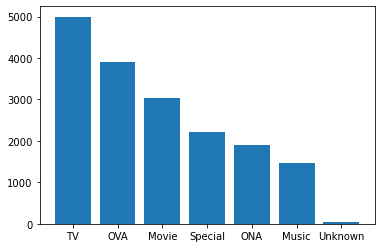

In [3]:
#simple bar graph to show types of anime in the database
plt.bar(anime_df["Type"].value_counts().index, anime_df["Type"].value_counts())
plt.show()

## Filtering

In [4]:
#Only keep television shows, movies and original net animation (a television show only released on a streaming service)
anime_df = anime_df.loc[anime_df["Type"].isin(["TV", "Movie", "ONA"])]

In [5]:
#remove scores of anime that are unknown
anime_df = anime_df.loc[anime_df["Score"] != "Unknown"]

In [6]:
#Removes Hentai (anime porn) from the database as they arent on streaming services and we wouldn't want to recommend them
anime_df = anime_df.loc[~anime_df["Genres"].str.contains("Hentai")]

In [7]:
#new column to split Aired column up to get the anime's airing year
anime_df["Aired_Split"] = [aired.split() for aired in anime_df["Aired"]]
anime_df["Aired_Split"]
started_airing = []
#since the aired column is written in different ways, we must use an if statement to find the corresponding year in the split
for row in anime_df["Aired_Split"]:
    if len(row) == 1:
        started_airing.append(row[0])
    elif len(row) == 2:
        started_airing.append(row[1])
    else:
        if row[2] == "to":
            started_airing.append(row[1])
        elif row[2] == "?":
            started_airing.append(row[0])
        else:
            started_airing.append(row[2])
#new column to track anime's airing year
anime_df["Aired_Year"] = started_airing
#remove two unknown aired years
anime_df = anime_df.loc[anime_df["Aired_Year"] != "Unknown"]
anime_df["Aired_Year"] = anime_df["Aired_Year"].astype(int)

In [8]:
#Removed animes that premiered in the year 2020 as the database is from February 2020
#Anime released would either not be out or not have enough reviews at that point
anime_df = anime_df.loc[anime_df["Aired_Year"] < 2020]

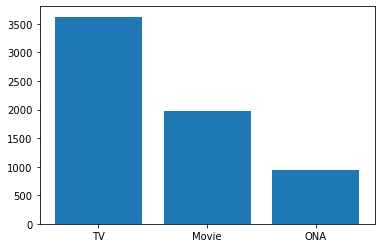

In [9]:
#simple bar graph to show updated types of anime in the database
plt.bar(anime_df["Type"].value_counts().index, anime_df["Type"].value_counts())
plt.show()

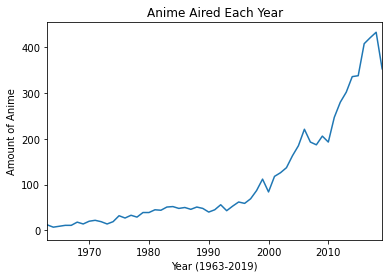

In [10]:
plt.plot(anime_df["Aired_Year"].value_counts().sort_index())
plt.title("Anime Aired Each Year")
plt.xlabel("Year (1963-2019)")
plt.ylabel("Amount of Anime")
plt.xlim(1963, 2019) #1963 being Astro Boy's airing and being regarded as the godfather of anime to come
plt.show()

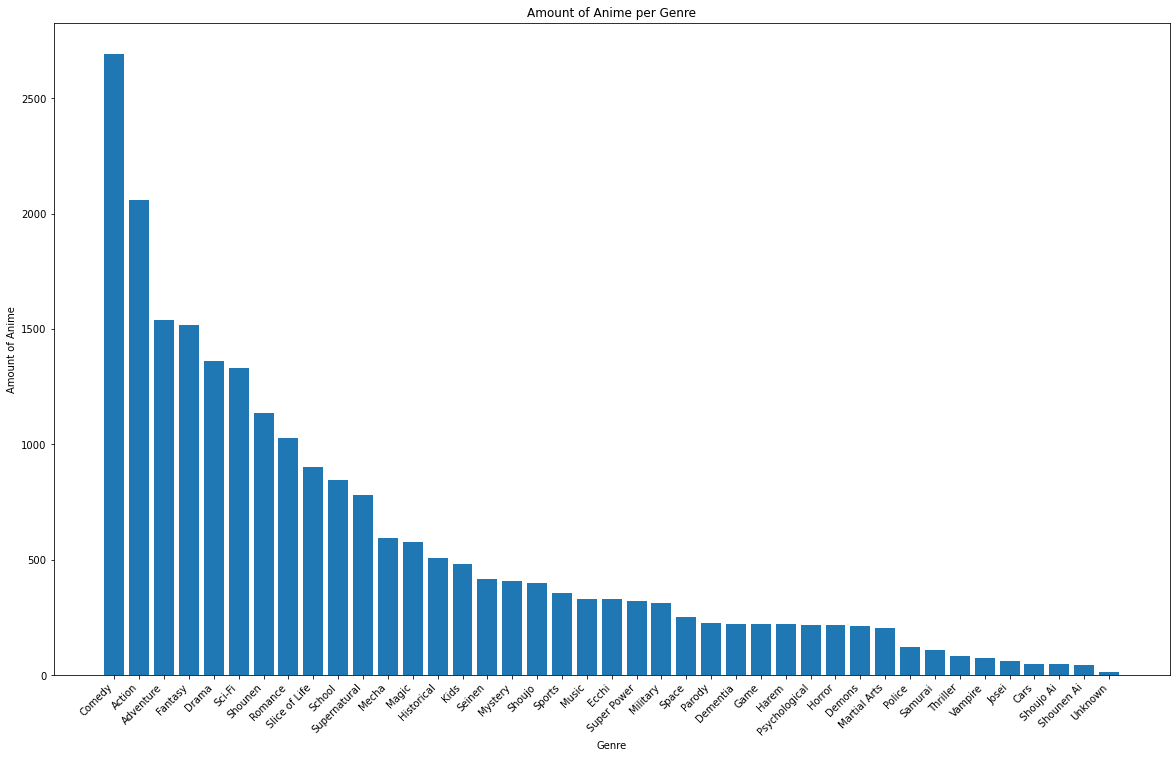

In [11]:
#Splits Genres column into a list of Genres
anime_df["Genres"] = [genre.split(", ") for genre in anime_df["Genres"]]

#Gets anime counts of amount of each genre
genre_count = {}
for anime in anime_df["Genres"]:
    for genre in anime:
        if genre in genre_count:
            genre_count[genre] += 1
        else:
            genre_count[genre] = 1
genre_df = pd.DataFrame.from_dict({"Genre":list(genre_count.keys()), "Amount":list(genre_count.values())})
genre_df = genre_df.sort_values("Amount", ascending=False)

#bar chart to check out amount of anime per genre
plt.figure(figsize=(20,12))
plt.bar(genre_df["Genre"], genre_df["Amount"])
plt.xticks(rotation=45, ha="right")
plt.title("Amount of Anime per Genre")
plt.xlabel("Genre")
plt.ylabel("Amount of Anime")
plt.show()

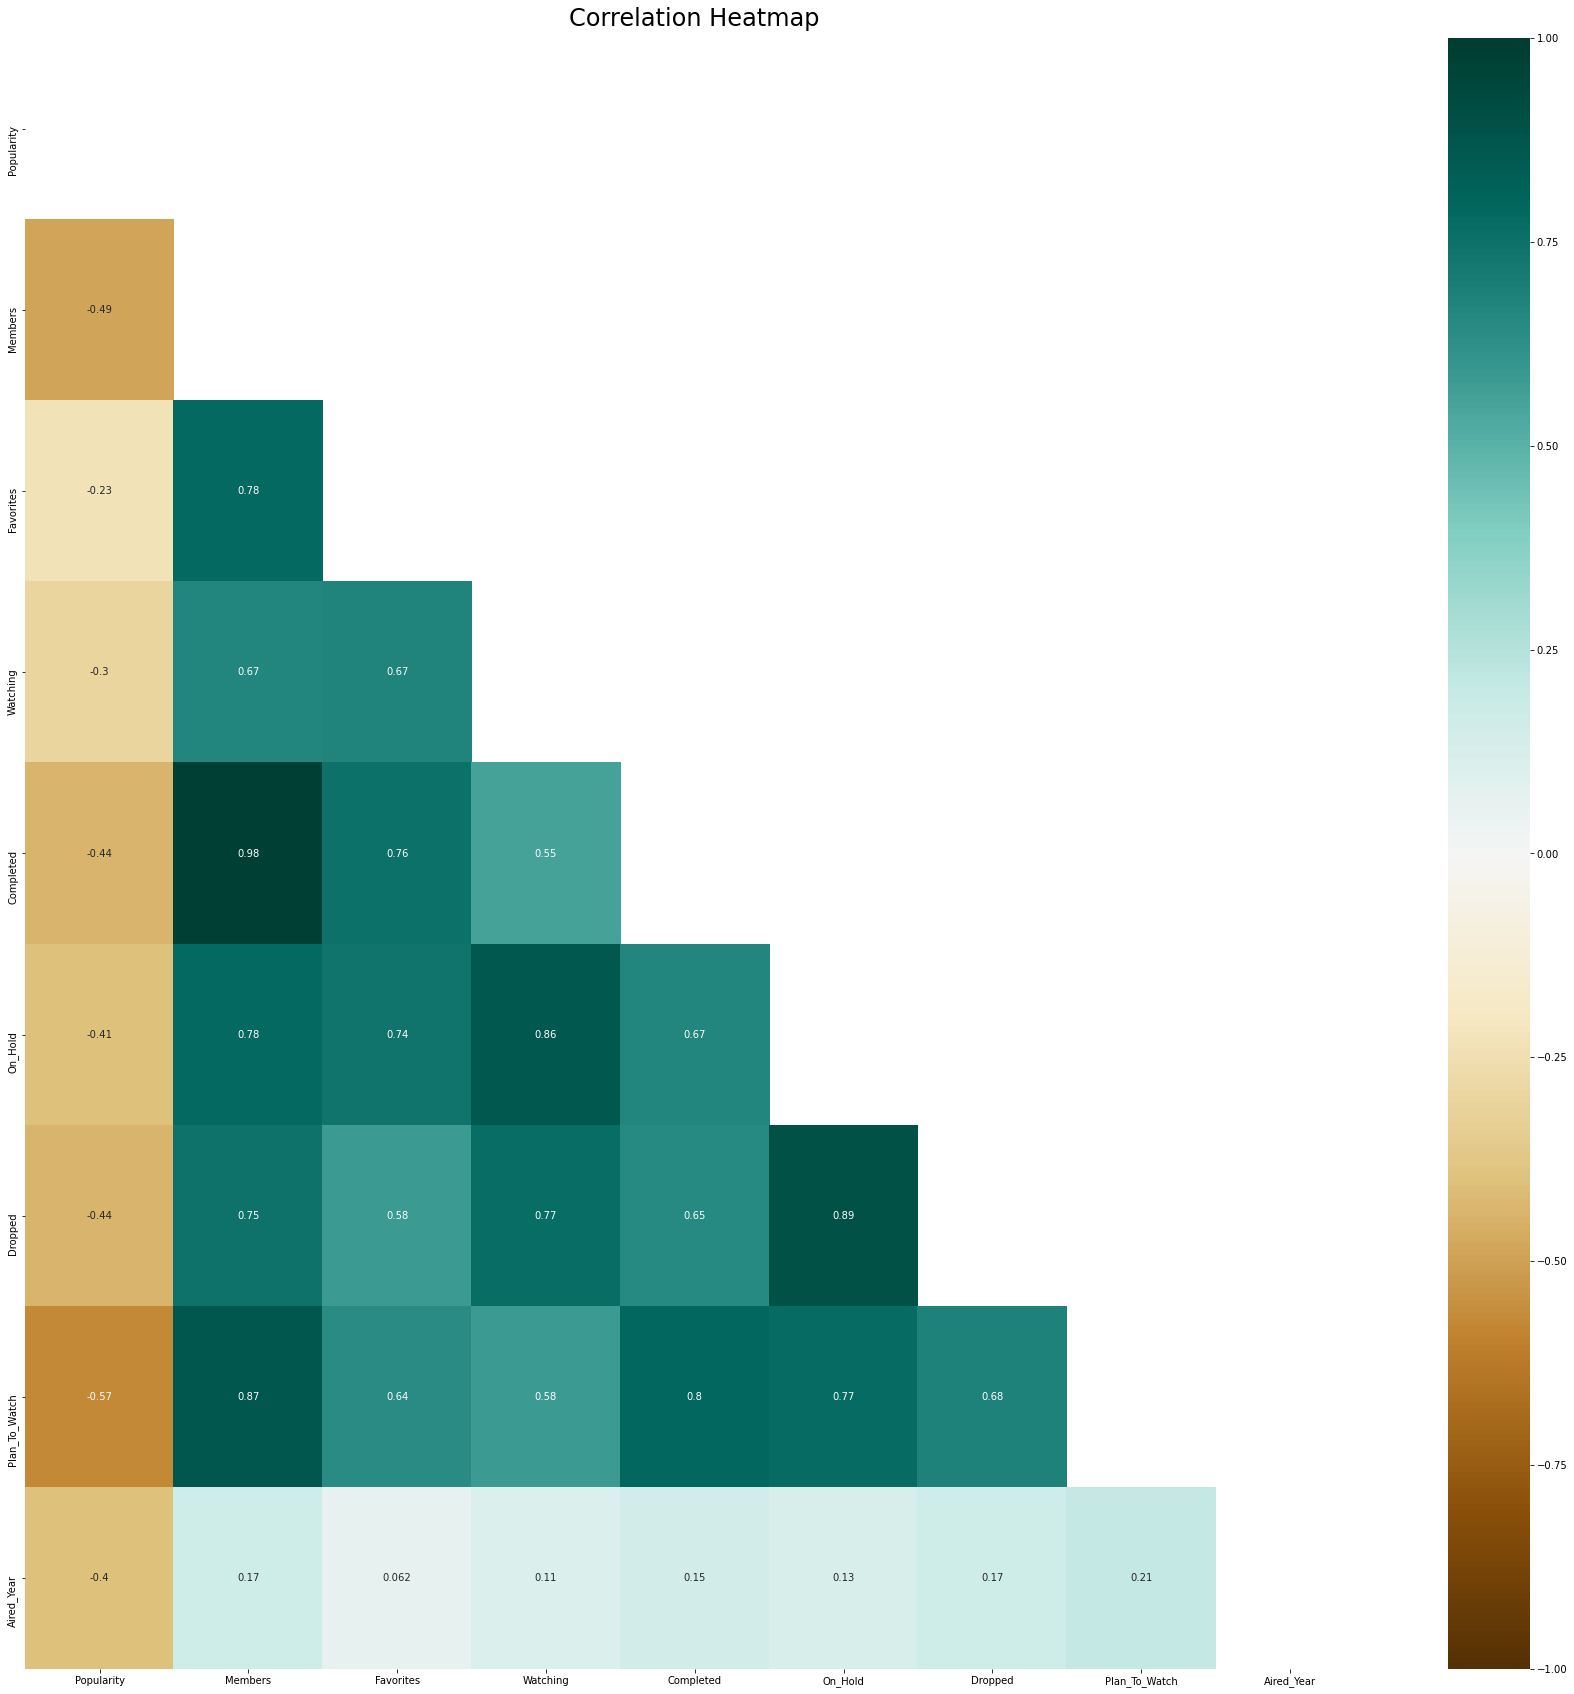

In [12]:
#column correlations between each other
corr_matrix = anime_df.drop(columns=["MAL_ID"]).corr()

plt.figure(figsize=(30, 30))

mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

heatmap = sns.heatmap(corr_matrix, vmin=-1, mask=mask, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':24}, pad=12);

In [13]:
#removes users with more than 1612 reviews(3 standard deviations away)
no_power_users = [key for key, val in dict(ratings_df["user_id"].value_counts().sort_index()).items() if val < 1612]
ratings_df = ratings_df.loc[ratings_df["user_id"].isin(no_power_users)]

In [14]:
#gets a random sample of 20,000 different users
random_users = list(ratings_df["user_id"].drop_duplicates().sample(n=20000, random_state=42).values)
ratings_df = ratings_df.loc[ratings_df["user_id"].isin(random_users)]

## Data Merge

In [15]:
#merges 20,000 users with the filtered anime
df = anime_df.merge(ratings_df, left_on = "MAL_ID", right_on = "anime_id").drop(["anime_id", "Aired_Split"], axis="columns")
#renames columns for common style
df = df.rename(columns={"user_id":"User_ID","rating":"Rating","watching_status":"Watching_Status",
                          "watched_episodes":"Watched_Episodes"})
#removed anime that had a rating of 0 as that would mean they havent watched it or didnt rate it
df = df.loc[df["User_Rating"] > 0]

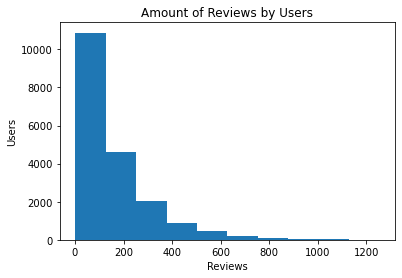

In [16]:
#histogram to check how many reviews per user
plt.hist(df["User_ID"].value_counts())
plt.xlabel("Reviews")
plt.ylabel("Users")
plt.title("Amount of Reviews by Users")
plt.show()

## Surprise

In [17]:
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(df[["User_ID", "MAL_ID", "User_Rating"]], reader)
train, test = train_test_split(data, test_size=.2, random_state=42)

In [18]:
#algorithm 1
algo1 = SVD(random_state = 42)
algo1.fit(train)
predictions1 = algo1.test(test)
accuracy.rmse(predictions1)

RMSE: 1.2306


1.2305760088048199

In [19]:
#algorithm 2
algo2 = NMF(random_state = 42)
algo2.fit(train)
predictions2 = algo2.test(test)
accuracy.rmse(predictions2)

RMSE: 2.1474


2.1473689217898304

In [20]:
#algorithm 3
algo3 = KNNBasic(random_state = 42)
algo3.fit(train)
predictions3 = algo3.test(test)
accuracy.rmse(predictions3)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3373


1.3372836000133013

In [21]:
#method to get recommendations to a user
def get_top_n(predictions, n=5):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [22]:
testset = train.build_anti_testset()
predictions = algo1.test(testset)

In [23]:
top_n = get_top_n(predictions, n=5)

## Conclusions

We decided to use SVD our algorithm as it had the best value of RMSE at about 1.2. From there we were able to recommend 5 different anime a user might want to watch.

## Next Steps

1. Streaming Service: Further filter out anime that isn’t in our streaming service as it wouldn't make sense to recommend or look at anime that isn't ours.
2. Demographics: See how age and gender affect recommendations and how we can use that to better recommend.
3. Merch: See how we can advertise merch based on their reviews to make a larger profit margin

## Appendix

In [24]:
#Looked into merging in all anime synopsis but it did not seem like it would end up being useful in recommending
#as the synopsises don't really share common words
#synopsis = pd.read_csv("data/MyAnimeList/anime_with_synopsis.csv")
#synopsis = synopsis.rename(columns={"sypnopsis" : "Synopsis"})
#synopsis = synopsis[["MAL_ID", "Synopsis"]]
#anime = anime.merge(synopsis, how = "left", left_on = "MAL_ID", right_on = "MAL_ID")

In [25]:
#method in making binary columns for the different types of anime
def typeBinary(anime_type, looking_for):
    if looking_for == "TV" and anime_type == "TV":
        return 1
    elif looking_for == "ONA" and anime_type == "ONA":
        return 1
    elif looking_for == "Movie" and anime_type == "Movie":
        return 1
    return 0
    
#anime_df["TV"] = [typeBinary(anime, "TV") for anime in anime_df["Type"]]
#anime_df["ONA"] = [typeBinary(anime, "ONA") for anime in anime_df["Type"]]
#anime_df["Movie"] = [typeBinary(anime, "Movie") for anime in anime_df["Type"]]

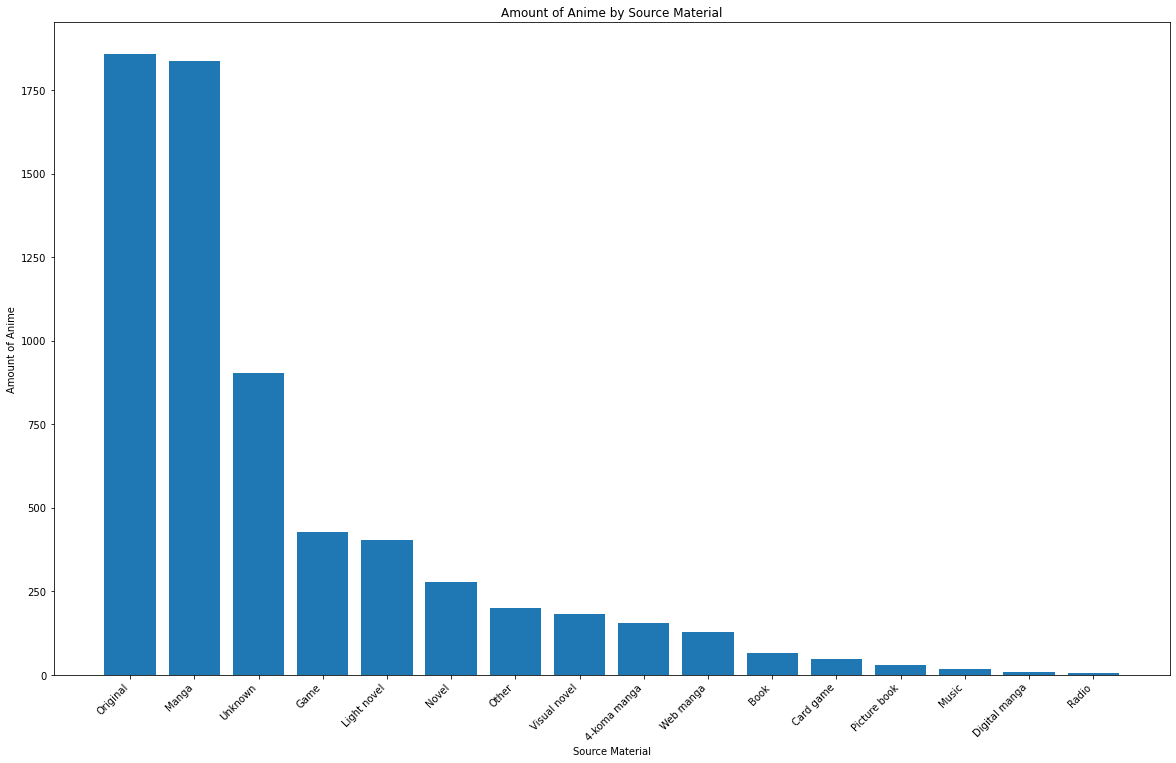

In [26]:
#bar chart to amount of anime created from different source material
plt.figure(figsize=(20,12))
plt.bar(anime_df["Source"].value_counts().index, anime_df["Source"].value_counts().values)
plt.xticks(rotation=45, ha="right")
plt.title("Amount of Anime by Source Material")
plt.xlabel("Source Material")
plt.ylabel("Amount of Anime")
plt.show()

In [30]:
anime_df[["Favorites", "Name"]].sort_values(by="Favorites", ascending=False).head(10)

,Favorites,Name
3971,183914,Fullmetal Alchemist: Brotherhood
5683,148452,Steins;Gate
6474,147274,Hunter x Hunter (2011)
1393,145201,Death Note
7449,129844,Shingeki no Kyojin
11,126645,One Piece
1431,90487,Code Geass: Hangyaku no Lelouch
1574,84651,Naruto: Shippuuden
20,71308,Neon Genesis Evangelion
11308,71054,Kimi no Na wa.


In [31]:
anime_df[["Members", "Name"]].sort_values(by="Members", ascending=False).head(10)

,Members,Name
1393,2589552,Death Note
7449,2531397,Shingeki no Kyojin
3971,2248456,Fullmetal Alchemist: Brotherhood
6614,2214395,Sword Art Online
10451,2123866,One Punch Man
11185,1909814,Boku no Hero Academia
8646,1895488,Tokyo Ghoul
10,1830540,Naruto
5683,1771162,Steins;Gate
8148,1751054,No Game No Life
